# Packages Import

In [1]:
import re #PRETRAITEMENT
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle


# 1- Business and Data UNserstanding

In [2]:
# Charger les données
df = pd.read_excel("D:/Ingenierie année 2/SEMESTRE 2/Data Science/NLP_ewe_dataset.xlsx")
df.head()


,id,Traduction,Sentiment,Ewe,Auteur,Document
0,0,"Pour raison de santé, j’ai gardé le lit ces de...",Negative,metsi anyimlɔƒe ŋkeke eve siawo le dɔlélé ta,https://aphtalcisse.tg/,Blog
1,1,"désormais, je suis maigre comme un clou de cad...",Negative,meɖi ku abe zogbeti ene,https://aphtalcisse.tg/,Blog
2,2,"Voilà alors par compassion, ma belle-mère m’i...",Neutre,esia tae lɔ̃xonye kpem be mava ɖu nu kpli yewo...,https://aphtalcisse.tg/,Blog
3,3,Nous sommes le 26 avril,Neutre,egbee nye tedoxe 26 lia,https://aphtalcisse.tg/,Blog
4,4,C'est la veille dun 27 avril,Neutre,edo ʋɔ na tedoxe 27 lia aɖe,https://aphtalcisse.tg/,Blog


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3056 non-null   int64 
 1   Traduction  3056 non-null   object
 2   Sentiment   3056 non-null   object
 3   Ewe         3056 non-null   object
 4   Auteur      3056 non-null   object
 5   Document    3056 non-null   object
dtypes: int64(1), object(5)
memory usage: 143.4+ KB


In [4]:
df.Sentiment.value_counts()


Sentiment
Negative    1080
Positive    1072
Neutre       904
Name: count, dtype: int64

#Cette base est composé de : 3056 exemples 3 classes dont Positive, Negative et Neutre 

## Visualisation

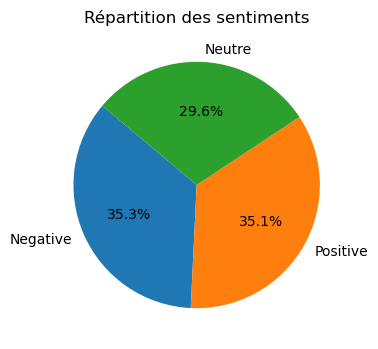

In [5]:
import matplotlib.pyplot as plt

# Compter le nombre de occurrences de chaque sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Créer un diagramme à secteurs
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des sentiments')
plt.show()

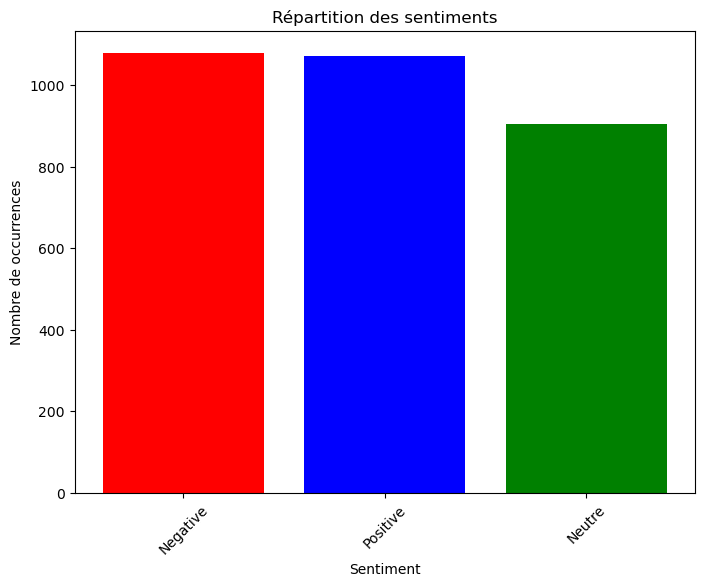

In [6]:
import matplotlib.pyplot as plt

# Compter le nombre de occurrences de chaque sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Créer un diagramme à barres
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'blue', 'green'])
plt.title('Répartition des sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de occurrences')
plt.xticks(rotation=45)
plt.show()

# 2- Data Preparation

### 2.1. Data Cleaning

In [7]:
features=df.iloc[:,3]
features

0            metsi anyimlɔƒe ŋkeke eve siawo le dɔlélé ta
1                                 meɖi ku abe zogbeti ene
2       esia tae lɔ̃xonye kpem be mava ɖu nu kpli yewo...
3                                 egbee nye tedoxe 26 lia
4                             edo ʋɔ na tedoxe 27 lia aɖe
                              ...                        
3051                       Dzidzedzewo dzi wɔwɔ pɛpɛpɛ o.
3052    Woto vovo, ɣeaɖewoɣi la, esẽna ŋutɔ le atike s...
3053                   Kɔkɔ, vevietɔ na atikewɔwɔ yeyewo.
3054    Gazazã gãwo kple mɔnukpɔkpɔ sue aɖe ko na ame ...
3055    Ẽ, ne wozãe le mɔ gbegblẽ nu alo womekpɔ edzi ...
Name: Ewe, Length: 3056, dtype: object

In [8]:
labels=df.iloc[:,2]
labels

0       Negative
1       Negative
2         Neutre
3         Neutre
4         Neutre
          ...   
3051    Negative
3052    Negative
3053    Negative
3054    Negative
3055    Negative
Name: Sentiment, Length: 3056, dtype: object

In [9]:
features[4]

'edo ʋɔ na tedoxe 27 lia aɖe'

#### - Il est essentiel de garder les accent(ẽ,é,ɔ̃,ã...) et les caractere particulier telle que (ɣ,ɔ,ƒ,ɖ...) qui peuvent changer completement le sens d'une phrase

#### -  On ne peut également pas supprimé les mots contenant une seule lettre car en ewe, une seule lettre peut avoir un sens ( exemple de 'o' qui stipule la négation) 

In [10]:
tidy_features=[]
for i in range(len(features)):
    tmp = re.sub(r'\d+', ' ', str(features[i]))  # Supprime les nombres
    tmp=re.sub(r'\s+',' ',tmp)# Supprime les espaces multiples
    tmp=tmp.lower() #Convertit en minuscules
    tmp = re.sub(r'[^\w\s]', '', tmp) # Élimine la ponctuation
    tidy_features.append(tmp)
tidy_features

['metsi anyimlɔƒe ŋkeke eve siawo le dɔlélé ta',
 'meɖi ku abe zogbeti ene',
 'esia tae lɔxonye kpem be mava ɖu nu kpli yewo ale be magakpɔ ŋuse',
 'egbee nye tedoxe lia',
 'edo ʋɔ na tedoxe lia aɖe',
 'ɣetrɔ sia ƒe nuɖuɖu nye fufu kple fufutsi si me agbitsa dotɛ kple kanami le',
 'megbɔdzɔ eye nuɖuɖu mele dzroyem o gake miatɔ edzi kpɔ',
 'tonye be ablɔɖe vavae nye be miaɖu nu aɖi ƒo',
 'ŋtɔŋtɔ ppa nyawo neto',
 'nyawoe',
 'mieklɔ asi eye papa yra nu ɖuɖua eye ɖeko mie ɖe amen teti ko ceet tso latrikia',
 'asaa dzi do viviti',
 'magate ŋu kpɔ ame aɖeke o',
 'ƒè ablɔɖexɔxɔ kage womate ŋu na latriki dukɔa o',
 'eh papa ŋukpenyae lo',
 'ke esi wonye be asi mebua nugbɔmɔ o ta la miedze nua ɖuɖu',
 'ɖoɖui zi negbe aɖeƒoƒo kple asiɖiɖɔe koe le ɖiɖim',
 'memi fufukɔ etɔ agbitsa eve kple dotɛ ɖeka kasia nye alɔ dze la si le agbaa titina dzi',
 'melee see',
 'deka eve etɔ ene eye nye alɔ kli asibiɖe eve bubu eve nyɛɛ wona dzoa',
 'miegbɔ fuu',
 'papa elias dze la didi le agbaa me',
 'etsa ŋku g

In [11]:
tidy_features[4]

'edo ʋɔ na tedoxe lia aɖe'

## 2.2. Word Embedding using TF-IDF Vectoizer 

In [12]:
# Initialization of the TF-IDF Vectorizer
# avant faire nltk.download('stopwords')
vectorizer= TfidfVectorizer(max_features=3000, min_df=4, max_df=0.3)


# Apply the vectorizer on the tidy_feautres
X=vectorizer.fit_transform(tidy_features).toarray()
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53540381, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 2.3. Diviser les données en donnée d'apprentissage et de Test 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [14]:
X_test.shape

(612, 1265)

## 3. Machine Learning 

In [15]:
# Instanciation des classificateurs
neural = MLPClassifier(hidden_layer_sizes=(100,150), activation='logistic', solver='adam')
gnb = GaussianNB()
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
sgd_svm = SVC(kernel='sigmoid')
poly_svm = SVC(kernel='poly', degree=2)

In [16]:
#Training of ML algo
neural.fit(X_train,y_train)
gnb.fit(X_train,y_train)
linear_svm.fit(X_train,y_train)
rbf_svm.fit(X_train,y_train)
sgd_svm.fit(X_train,y_train)
poly_svm.fit(X_train,y_train)

C:\Users\debgn\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


SVC(degree=2, kernel='poly')

In [17]:
# prédiction
y_pred_neural=neural.predict(X_test)
y_pred_gnb=gnb.predict(X_test)
y_pred_linear_svm=linear_svm.predict(X_test)
y_pred_rbf_svm=rbf_svm.predict(X_test)
y_pred_sgd_svm=sgd_svm.predict(X_test)
y_pred_poly_svm=poly_svm.predict(X_test)


In [18]:
print("****************************** Performance Evaluation of Naive Bayes****************************************")
print(classification_report(y_test,y_pred_gnb))
print("****************************** Performance Evaluation of Linear SVM*****************************************")
print(classification_report(y_test,y_pred_linear_svm))
print("****************************** Performance Evaluation of RBF SVM********************************************")
print(classification_report(y_test,y_pred_rbf_svm))
print("****************************** Performance Evaluation of SGD SVM********************************************")
print(classification_report(y_test,y_pred_sgd_svm))
print("****************************** Performance Evaluation of Polynomial SVM ************************************")
print(classification_report(y_test,y_pred_poly_svm))
print("****************************** Performance Evaluation of MLP Classifier*************************************")
print(classification_report(y_test,y_pred_neural))

****************************** Performance Evaluation of Naive Bayes****************************************
              precision    recall  f1-score   support

    Negative       0.50      0.27      0.35       199
      Neutre       0.47      0.61      0.53       196
    Positive       0.62      0.70      0.65       217

    accuracy                           0.53       612
   macro avg       0.53      0.53      0.51       612
weighted avg       0.53      0.53      0.52       612

****************************** Performance Evaluation of Linear SVM*****************************************
              precision    recall  f1-score   support

    Negative       0.55      0.62      0.58       199
      Neutre       0.57      0.52      0.54       196
    Positive       0.70      0.68      0.69       217

    accuracy                           0.61       612
   macro avg       0.61      0.60      0.60       612
weighted avg       0.61      0.61      0.61       612

********************

In [19]:
pickle.dump(vectorizer,open('vectorizer.pickle',"wb"))
pickle.dump(poly_svm,open('best_modelNLP.pickle',"wb"))